In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import sys
import wave
import copy
import math
import tensorflow as tf

from keras.models import Sequential, Model, load_model
from keras.layers.core import Dense, Activation
# from keras.layers import LSTM, Input, Flatten, Merge, Bidirectional
from keras.layers import LSTM, Input, Flatten, Bidirectional, Concatenate
from sklearn.preprocessing import label_binarize
from textblob import TextBlob

from Code.Misc.helper import *
from Code.Misc.features import *
import tqdm
%matplotlib inline

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

load = True

In [2]:
# set up global variable
code_path = os.path.dirname(os.path.realpath(os.getcwd()))
data_path = code_path + "/../data/"
sessions = ['Session1', 'Session2', 'Session3', 'Session4', 'Session5']
framerate = 16000

In [3]:
emotions_used = np.array(['ang', 'exc', 'neu', 'sad'])

# Load in data
import pickle
with open("../Misc/Saved_data/data_collected_full.pickle", 'rb') as handle:
    data2 = pickle.load(handle)

In [4]:
# this method is used to extract features from the input wav
def calculate_features(frames, freq, options):
    window_sec = 0.1
    window_n = int(freq * window_sec)

    st_f = stFeatureExtraction(frames, freq, window_n, window_n / 2)

    if st_f.shape[1] > 2:
        i0 = 1
        i1 = st_f.shape[1] - 1
        if i1 - i0 < 1:
            i1 = i0 + 1

        deriv_st_f = np.zeros((st_f.shape[0], i1 - i0), dtype=float)
        for i in range(i0, i1):
            i_left = i - 1
            i_right = i + 1
            deriv_st_f[:st_f.shape[0], i - i0] = st_f[:, i]
        return deriv_st_f
    elif st_f.shape[1] == 2:
        deriv_st_f = np.zeros((st_f.shape[0], 1), dtype=float)
        deriv_st_f[:st_f.shape[0], 0] = st_f[:, 0]
        return deriv_st_f
    else:
        deriv_st_f = np.zeros((st_f.shape[0], 1), dtype=float)
        deriv_st_f[:st_f.shape[0], 0] = st_f[:, 0]
        return deriv_st_f

def get_signal_pol(r, signal):
    # get text transcript from signal
    text = r.recognize_google(signal)
    # polarity is the average sentiment of the phrase that was spoken
    sentiment = TextBlob(text).polarity
    return sentiment

In [8]:
load = False
import speech_recognition as sr
from speech_recognition import AudioData

r = sr.Recognizer()

# generating training data take a while, here we load the training data into the np array from a file
x_train_file = "../Misc/Saved_data/x_test_speech.npy"

if load:
    with open(x_train_file, 'rb') as f:
        x_train_speech = np.load(f)
else:
    # set up the training set
    x_train_speech = []
    x_transcript = []
    x_transcript_pol_only = []
    x_transcript_auto = []

    counter = 0
    framerate = 16000
    for ses_mod in tqdm.tqdm(data2):
        x_head = ses_mod['signal']
        wav_meta = ses_mod['wav_meta']
        st_features = calculate_features(x_head, framerate, None)
        st_features, _ = pad_sequence_into_array(st_features, maxlen=100)
        x_train_speech.append( st_features.T )

        # audio_wav = AudioData(frame_data = x_head,
        #                       sample_rate = wav_meta['framerate'],
        #                       sample_width = wav_meta['sampwidth'])

        # try:
        #     auto_transcription = r.recognize_google(audio_wav)
        #     x_transcript_auto.append(TextBlob(auto_transcription).polarity)
        # except:
        #     x_transcript_auto.append(0.0)

        x_transcript_pol_only.append(TextBlob(ses_mod['transcription']).polarity)

        x_transcript.append([TextBlob(ses_mod['transcription']).polarity,
                             TextBlob(ses_mod['transcription']).subjectivity])

    x_train_speech = np.array(x_train_speech)
    x_transcript = np.array(x_transcript)
    x_transcript_pol_only = np.array(x_transcript_pol_only)
    x_transcript_auto = np.array(x_transcript_auto)

    # save model after it has been trained
    with open(x_train_file, 'wb') as f:
        np.save(f, x_train_speech)

x_train_speech.shape

100%|██████████| 4936/4936 [19:14<00:00,  4.27it/s]  


(4936, 100, 34)

In [9]:
# split labels from training data
Y_raw =[]
for ses_mod in tqdm.tqdm(data2):
    Y_raw.append(ses_mod['emotion'])


#converts labels into a one hot encoded version
Y = label_binarize(Y_raw ,emotions_used)

Y.shape

100%|██████████| 4936/4936 [00:00<00:00, 822758.99it/s]
F:\Program Files\Ananconda\envs\Tersorflow-gpu\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=['ang' 'exc' 'neu' 'sad'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


(4936, 4)

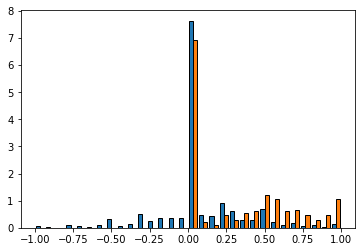

In [10]:
plt.hist(x_transcript, density=True, bins=30, ec="black")
plt.show()

# Models
<hr style="height:2px;border-width:0;color:black;background-color:black">

### Original audio only LST model

In [11]:
def lstm_model(optimizer='Adadelta'):
    model = Sequential()
    model.add(LSTM(512, return_sequences=True, input_shape=(100, 34)))
    model.add(LSTM(256, return_sequences=False))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dense(4))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model


In [14]:
#model_lstm = load_model("F:\Capstone Project\Capstone---RTSD-System\Code\Misc\Saved_data\Trained_models/2_layer_LSTM.pickle")

model_lstm = lstm_model()
time_start = time.time()
with tf.device('/gpu:0'):
    hist = model_lstm.fit(x_train_speech, Y,
                     batch_size=100, epochs=60, verbose=1, shuffle = True,
                     validation_split=0.2)
print("time elapsed: " + str(time.time() - time_start))

Epoch 1/60
40/40 [==============================] - 6s 57ms/step - loss: 1.3851 - accuracy: 0.3186 - val_loss: 1.3874 - val_accuracy: 0.3401

In [43]:
import random
int(random.random() * 10000)

6613

In [ ]:
import random

model_res = []
for x in tqdm.tqdm(range(0, 100)):
    max_res = 0
    rand_seed = int(random.random() * 1000)
    tf.random.set_seed(rand_seed)

    model_lstm = lstm_model()
    with tf.device('/gpu:0'):
        model_lstm.fit(x_train_speech, Y,
                     batch_size=100, epochs=60, verbose=0, shuffle = True,
                     validation_split=0.2)
    results = model_lstm.evaluate(x_train_speech[0:], Y[0:])#, batch_size=128)
    if max_res < results[1]:
        max_res = results[1]
        model_res.append([results[1], model_lstm, rand_seed])

print(max_res)

 99%|█████████▉| 99/100 [2:11:26<01:20, 80.25s/it]  

155/155 [==============================] - 2s 11ms/step - loss: 1.3698 - accuracy: 0.3712

In [15]:
print("Evaluate on test data")
results = model_lstm.evaluate(x_train_speech[0:], Y[0:])#, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
155/155 [==============================] - 2s 12ms/step - loss: 1.3697 - accuracy: 0.3687

### Multi_modal Model: Audio + Text (Polarity only)

In [12]:
class multi_modal_model_class_pol(Model):
    def __init__(self, optimizer='Adadelta'):
        super(multi_modal_model_class_pol, self).__init__()

        # the first branch operates on the audio input
        self.model_audio = Sequential()
        self.model_audio.add(LSTM(512, return_sequences=True, input_shape=(100, 34)))
        self.model_audio.add(LSTM(256, return_sequences=False))
        self.model_audio.add(Dense(512, activation="relu"))

        # the second branch operates on the transcription input
        self.model_text = Dense(1, activation="relu")

        # apply a FC layer and then a regression prediction on the
        # combined outputs
        self.dense = Dense(4, activation="softmax")

    def call(self, input) :
        inputAudio = input[0]
        inputText = input[1]
        audio_y = self.model_audio(inputAudio)
        text_y = self.model_text(inputText)

        # combine the output of the two branches
        combined = Concatenate(axis=1)([audio_y, text_y])

        out = self.dense(combined)
        return out

#### Manual Transcription

In [ ]:
multi_model_1 = multi_modal_model_class_pol()
multi_model_1.compile(loss='categorical_crossentropy', optimizer="Adadelta", metrics=['accuracy'])

time_start = time.time()
with tf.device('/gpu:0'):
    hist = multi_model_1.fit([x_train_speech, x_transcript_pol_only], Y,
                 batch_size=30, epochs=60, verbose=1, shuffle = True,
                 validation_split=0.2)
print("time elapsed: " + str(time.time() - time_start))

Epoch 1/60
132/132 [==============================] - 9s 39ms/step - loss: 1.3878 - accuracy: 0.3251 - val_loss: 1.3810 - val_accuracy: 0.3664

In [ ]:
multi_model_1.summary()

In [ ]:
print("Evaluate on test data")
results = multi_model_1.evaluate([x_train_speech[0:], x_transcript_pol_only[0:]], Y[0:]) #, batch_size=128)
print("test loss, test acc:", results)

In [ ]:
with tf.device('/cpu:0'):
    hist = multi_model_1.fit([x_train_speech, x_transcript_pol_only], Y,
                     batch_size=100, epochs=40, verbose=1, shuffle = True,
                     validation_split=0.2)

#### Automatic Transcription


In [ ]:
# multi_model_1 = multi_modal_model_class_pol()
# multi_model_1.compile(loss='categorical_crossentropy', optimizer="Adadelta", metrics=['accuracy'])
#
# time_start = time.time()
# with tf.device('/gpu:0'):
#     hist = multi_model_1.fit([x_train_speech, x_transcript_auto], Y,
#                  batch_size=100, epochs=40, verbose=0, shuffle = True,
#                  validation_split=0.2)
# print("time elapsed: " + str(time.time() - time_start))

In [ ]:
print("Evaluate on test data")
results = multi_model_1.evaluate([x_train_speech[0:], x_transcript_pol_only[0:]], Y[0:]) #, batch_size=128)
print("test loss, test acc:", results)

### Multi_modal Model: Audio + Text (Polarity and Subjectivity)

In [ ]:
class multi_modal_model_class_pol_sub(Model):
    def __init__(self, optimizer='Adadelta'):
        super(multi_modal_model_class_pol_sub, self).__init__()

        # the first branch operates on the audio input
        self.model_audio = Sequential()
        self.model_audio.add(LSTM(512, return_sequences=True, input_shape=(100, 34)))
        self.model_audio.add(LSTM(256, return_sequences=False))
        self.model_audio.add(Dense(512, activation="relu"))

        #self.audio_y = Model(inputs=self.inputAudio, outputs=self.model_audio)

        # the second branch operates on the transcription input
        self.model_text = Dense(2, activation="relu")

        #self.text_y = Model(inputs=self.inputText, outputs=self.model_text)

        # apply a FC layer and then a regression prediction on the
        # combined outputs
        self.dense = Dense(4, activation="softmax")

    def call(self, input) :
        inputAudio = input[0]
        inputText = input[1]
        audio_y = self.model_audio(inputAudio)
        text_y = self.model_text(inputText)

        # combine the output of the two branches
        combined = Concatenate(axis=1)([audio_y, text_y])

        out = self.dense(combined)
        return out

In [ ]:
multi_model_2 = multi_modal_model_class_pol()
multi_model_2.compile(loss='categorical_crossentropy', optimizer="Adadelta", metrics=['accuracy'])

time_start = time.time()
with tf.device('/gpu:0'):
    hist = multi_model_2.fit([x_train_speech, x_transcript], Y,
                 batch_size=100, epochs=40, verbose=0, shuffle = True,
                 validation_split=0.2)
print("time elapsed: " + str(time.time() - time_start))

In [ ]:
print("Evaluate on test data")
results = multi_model_2.evaluate([x_train_speech[0:], x_transcript[0:]], Y[0:]) #, batch_size=128)
print("test loss, test acc:", results)

In [ ]:
class multi_modal_model_class_pol(Model):
    def __init__(self, optimizer='Adadelta'):
        super(multi_modal_model_class_pol, self).__init__()

        # the first branch operates on the audio input
        self.model_audio = Sequential()
        self.model_audio.add(LSTM(512, return_sequences=True, input_shape=(100, 34)))
        self.model_audio.add(LSTM(256, return_sequences=False))
        self.model_audio.add(Dense(512, activation="relu"))

        #self.audio_y = Model(inputs=self.inputAudio, outputs=self.model_audio)

        # the second branch operates on the transcription input
        self.model_text = Dense(1, activation="relu")

        #self.text_y = Model(inputs=self.inputText, outputs=self.model_text)

        # apply a FC layer and then a regression prediction on the
        # combined outputs
        self.dense = Dense(4, activation="softmax")

    def call(self, input) :
        inputAudio = input[0]
        inputText = input[1]
        audio_y = self.model_audio(inputAudio)
        text_y = self.model_text(inputText)

        # combine the output of the two branches
        combined = Concatenate(axis=1)([audio_y, text_y])

        out = self.dense(combined)
        return out


In [ ]:
predict_result_file = "../Misc/Saved_data/Trained_models/predict_result.npy"

if load:
    with open(predict_result_file, 'rb') as f:
        result = np.load(f)
else:
    result = model.predict(x_train_speech)
    with open(predict_result_file, 'wb') as f:
        np.save(f, result)

In [ ]:
# get prediction values for training data
label = tf.argmax(result, axis = 1)

#### We have to convert the encoded emotion labels back into a more readable format.

In [ ]:
# formatting the label data
cols = ['ang', 'exc', 'neu', 'sad']
col_y = []
df_real = pd.DataFrame(Y_raw, columns = ["emotion"])
for val in df_real["emotion"].values:
    x = 0
    for c in range(0,len(cols)):
        if cols[c] in val:
            col_y.append(c)
            break

df_real["val"] = col_y
print("Actual Labels")
df_real.head()

In [ ]:
# formatting the predicted data
cols = ['ang', 'exc', 'neu', 'sad']
col_y = []
df_pred = pd.DataFrame(label, columns=["val"])
for x in df_pred["val"].values:
    col_y.append(cols[x])

df_pred["emotion"] = col_y
print("Prediction Data")
df_pred.head()


### Dataset investigation

Looking into the distribution of the dataset, we can see a clear unbalance between neutral samples and samples that indicate a specific emotion.
Although this may make the model more likely to guess that a sample is neutral, this is representative of real conversation.

In [ ]:
pd.DataFrame(Y_raw).head()
## Plot emotion histogram for input data
plt.hist(Y_raw, bins=4, ec="black")  # `density=False` would make counts
plt.ylabel('Count')
plt.xlabel('Emotion')
plt.title("Distribution of classes in input data")

In [ ]:
#
plt.hist(df_pred["emotion"], bins=4, ec="black")
plt.ylabel('Count')
plt.xlabel('Emotion')
plt.title("Distribution of classes in prediction data")

### Confusion matrix

In [ ]:
import seaborn as sn
emotions = ['ang', 'exc', 'neu', 'sad']
## get avg between classes
df_res = pd.DataFrame(result)
df_label = pd.DataFrame(label)

df_emotion_conf = pd.DataFrame()

df_res.columns = emotions

df_res["emo"] = df_label[0]
df_emotion_conf = df_res.groupby(['emo']).mean()
df_emotion_conf["emo"] = emotions
df_emotion_conf = df_emotion_conf.set_index("emo")


plt.figure(figsize = (6, 5))
sn.heatmap(df_emotion_conf, annot=True)
plt.xlabel("Prediction")
plt.ylabel("Expected")
plt.title("Confusion matrix of mean confidence")

## Loading in new Wav file

In [ ]:
import IPython.display as ipd
audio_path = "F:/Capstone Project/IEMOCAP-Emotion-Detection/data/CMU_MOSI/Raw/Audio/WAV_11025/"
file_name = "PZ-lDQFboO8.wav"

#ipd.Audio(audio_path + file_name) # load a local WAV file

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
y, sr = librosa.load(audio_path + file_name, duration=10)
fig, ax = plt.subplots()
librosa.display.waveplot(y, sr=sr)
ax.label_outer()

In [ ]:
X = librosa.stft(y)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')

In [ ]:
wav = get_audio(audio_path, file_name)
(nchannels, sampwidth, framerate, nframes, comptype, compname), samples_wav = wav

#### Splitting the Wav into samples
after loading in a wav file to test on, we will be splitting it into a number of samples.
Each sample will be a 3 second slice of the original wav (The slice length can be changed by changing the timeq).
An overlap can also be used between samples, for this test we use a 1 second overlap

In [ ]:
len_wav = nframes / framerate # length of wav in seconds

timeq = 3 # length of sample slice in seconds
overlap = 1 # overlap between samples

left = samples_wav[0::nchannels]
right = samples_wav[1::nchannels]

samples = []
for t_start in range(0, int(len_wav), int(timeq)):
    if t_start > int(t_start):
        t_start = t_start

    if t_start == 0: #first sample
        start = t_start
        end = t_start + timeq
    else:
        start = t_start - overlap
        end = t_start + timeq - overlap

    if end > len_wav:
        end = len_wav
    sample_right = right[int(start * framerate):int(end * framerate)]
    sample_left = left[int(start * framerate):int(end * framerate)]
    # print("sample start: " + str(start) + " | sample end: " + str(end))

    #normalize data
    norm = np.linalg.norm(sample_left)
    normal_array = sample_left/norm

    samples.append(normal_array) #, 'right': sample_right})

#### Extracting features

In [ ]:
# set up the training set
wav_in = []

counter = 0
for ses_mod in samples:
    st_features = calculate_features(ses_mod, framerate, None)
    st_features, _ = pad_sequence_into_array(st_features, maxlen=100)
    wav_in.append( st_features.T )

wav_in = np.array(wav_in)
wav_in.shape

#### Predict on model

In [ ]:
import time
t0 = time.time()
wav_test_results = model.predict(wav_in)
print("time = " + str(time.time() - t0))
#wav_test_results

In [ ]:
wav_test_results_max = tf.argmax(wav_test_results, axis = 1)
wav_test_results.shape

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
# formatting the predicted data
cols = ['ang', 'exc', 'neu', 'sad']
col_y = []
df_pred_wav = pd.DataFrame(wav_test_results, columns=cols)

plt.figure(figsize=(20,10))
plt.plot(df_pred_wav['ang'], label="Anger", color='r')
plt.plot(df_pred_wav['exc'], label="Excited", color='y')
plt.plot(df_pred_wav['neu'], label="Neutral", color='g')
plt.plot(df_pred_wav['sad'], label="Sad", color='b')
plt.axhline(y=0.5, color='r', linestyle='--')
plt.legend(loc="upper left")
plt.show()

In [ ]:
x_train_test = x_train_speech[0:101]
y_test = Y[0:101]
import time
t0 = time.time()
res = model.predict(x_train_test)
print("time = " + str(time.time() - t0))
df = pd.DataFrame(res, columns=['ang', 'exc', 'neu', 'sad'])

In [ ]:
df.head()

## Real Time Audio Predictions

In [ ]:
# %matplotlib tk
cols = ['ang', 'exc', 'neu', 'sad']
df_pred_wav = pd.DataFrame(columns=cols)
fig , ax = plt.subplots()
ax.plot([0], label="Anger", color='r')
ax.plot([0], label="Excited", color='y')
ax.plot([0], label="Neutral", color='g')
ax.plot([0], label="Sad", color='b')


plt.legend(loc="upper left")

# x = np.arange(0, 50)
# line, = ax.plot(x)


graph_window = 10
for ses_mod in samples:
    #time.sleep(0.2)
    # Extract Features

    wav_in = []
    st_features = calculate_features(ses_mod, framerate, None)
    st_features, _ = pad_sequence_into_array(st_features, maxlen=100)
    wav_in.append( st_features.T )
    wav_in = np.array(wav_in)

    t0 = time.time()
    wav_test_results = model.predict(wav_in)
#     print("time = " + str(time.time() - t0))
    #print("prediction = " + str(wav_test_results))

    df_pred_wav = df_pred_wav.append({cols[0]:wav_test_results[0][0],
                        cols[1]:wav_test_results[0][1],
                        cols[2]:wav_test_results[0][2],
                        cols[3]:wav_test_results[0][3]
    }, ignore_index=True)

    df_pred_wav_view = df_pred_wav[df_pred_wav.shape[0] - graph_window : ]

    #plt.cla()

    ax.axhline(y=0.5, color='r', linestyle='--')
    ax.plot(df_pred_wav_view['ang'], label="Anger", color='r')
    ax.plot(df_pred_wav_view['exc'], label="Excited", color='y')
    ax.plot(df_pred_wav_view['neu'], label="Neutral", color='g')
    ax.plot(df_pred_wav_view['sad'], label="Sad", color='b')

    fig.canvas.draw()
    fig.canvas.flush_events()
print("Finished")